Load libraries and functions defined in other scripts

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from DataHandling import (
    get_yield_and_rates,
    get_call_surface,
    implied_vol_call
)
from plots_and_metrics import (
    plot_market_and_model_surface,
    plot_smiles_market_vs_model,
    compute_iv_errors,
    plot_smiles_all_models,
    plot_smiles_vg_models
)

from SV import Lewis_call_option_pricing_sinh_tan as Lewis_call_option_pricing_sinh_tan_SV
from SV import loss as loss_sv

from SVJ import Lewis_call_option_pricing_sinh_tan as Lewis_call_option_pricing_sinh_tan_SVJ
from SVJ import loss as loss_svj

from SVJJ import (
    Lewis_call_option_pricing_sinh_tan, 
    loss
)

from VG import (
        VGParams as VGParams_VG,
        calibrate_vg_full_surface,
        price_slice_vg_maturity,
    )

from VG_CIR import (
        VGParams as VGParams_CIR,
        CIRParams,
        calibrate_joint_full_surface as calibrate_vgcir,
        price_slice_tcvg_maturity as price_vgcir_slice,
    )

Load filtered data and get inferred yield and rates

In [2]:
S0 = 3094.04
q, r, _ = get_yield_and_rates()
df = get_call_surface()

Calibrate Heston (SV) model

In [3]:
# x = [kappa, theta, eta, rho, v0]
x0_sv = np.array([2.0, 0.04, 0.5, -0.6, 0.04])

# Bounds
bnds_sv = [
    (1e-4, 50.0),     # kappa
    (1e-6, 5.0),      # theta
    (1e-4, 10.0),     # eta
    (-0.999, 0.999),  # rho
    (1e-8, 5.0),      # v0
]

# Step 1: Nelder–Mead
res0 = minimize(lambda x: loss_sv(x, q, S0, df), x0_sv,
                method="Nelder-Mead",
                options={"maxiter": 50})

# Step 2: L-BFGS-B
res_sv = minimize(lambda x: loss_sv(x, q, S0, df), res0.x,
                    method="L-BFGS-B",
                    bounds=bnds_sv,
                    options={"maxiter": 50})

params_sv = res_sv.x
print("\nCalibrated SV (Heston) Parameters [kappa, theta, eta, rho, v0]:")
print(params_sv)

# Pricing for plots
sv_prices = []
for _, row in df.iterrows():
    sv_prices.append(
        Lewis_call_option_pricing_sinh_tan_SV(
            S0, row["Strike"], row["T"], row["r"], q,
            kappa=params_sv[0],
            theta=params_sv[1],
            eta=params_sv[2],
            rho=params_sv[3],
            V_t=params_sv[4],
            N=4096, alpha=1.2, L=24.0
        )
    )

df["IV_model"] = [
    implied_vol_call(p, S0, K, T, r0, q)
    for p, K, T, r0 in zip(sv_prices, df["Strike"], df["T"], df["r"])
]

df["IV_SV"] = df["IV_model"]

# Visualize
# plot_market_and_model_surface(df, 80, "SV (Heston) Model")
# plot_smiles_market_vs_model(df, 80, "SV (Heston) Model")
print("SV (Heston) IV Error (RMSE):", compute_iv_errors(df))


Calibrated SV (Heston) Parameters [kappa, theta, eta, rho, v0]:
[ 5.01977124  0.04220605  1.26489665 -0.72583155  0.01137856]
SV (Heston) IV Error (RMSE): ['ARPE_IV: 0.0249234659', 'RMSE_IV: 0.0062521312']


Calibrate SVJ model

In [4]:
# x = [kappa, theta, eta, rho, v0, Lambda, mu_J, sigma_J]
x0_svj = np.array([2.0, 0.04, 0.5, -0.6, 0.04, 0.20, -0.05, 0.15])

# Bounds
bnds_svj = [
    (1e-4, 50.0),       # kappa
    (1e-6, 5.0),        # theta
    (1e-4, 10.0),       # eta
    (-0.999, 0.999),    # rho
    (1e-8, 5.0),        # v0
    (0.0, 10.0),        # Lambda
    (-2.0, 2.0),        # mu_J
    (1e-6, 3.0),        # sigma_J
]

# Step 1: Nelder–Mead
res0 = minimize(lambda x: loss_svj(x, q, S0, df), x0_svj,
                method="Nelder-Mead",
                options={"maxiter": 50})

# Step 2: L-BFGS-B
res_svj = minimize(lambda x: loss_svj(x, q, S0, df), res0.x,
                    method="L-BFGS-B",
                    bounds=bnds_svj,
                    options={"maxiter": 50})

params_svj = res_svj.x
print("\nCalibrated SVJ Parameters [kappa, theta, eta, rho, v0, Lambda, mu_J, sigma_J]:")
print(params_svj)

# Pricing for plots
svj_prices = []
for _, row in df.iterrows():
    svj_prices.append(
        Lewis_call_option_pricing_sinh_tan_SVJ(
            S0, row["Strike"], row["T"], row["r"], q,
            kappa=params_svj[0],
            theta=params_svj[1],
            eta=params_svj[2],
            rho=params_svj[3],
            V_t=params_svj[4],
            Lambda=params_svj[5],
            mu_J=params_svj[6],
            sigma_J=params_svj[7],
            N=4096, alpha=1.2, L=24.0
        )
    )

df["IV_model"] = [
    implied_vol_call(p, S0, K, T, r0, q)
    for p, K, T, r0 in zip(svj_prices, df["Strike"], df["T"], df["r"])
]

df["IV_SVJ"] = df["IV_model"]

# Visualize
# plot_market_and_model_surface(df, 80, "SVJ (Heston + Jumps) Model")
# plot_smiles_market_vs_model(df, 80, "SVJ (Heston + Jumps) Model")
print("SVJ IV Error (RMSE):", compute_iv_errors(df))


Calibrated SVJ Parameters [kappa, theta, eta, rho, v0, Lambda, mu_J, sigma_J]:
[ 2.1275471   0.04837695  0.77834802 -0.75884088  0.01390123  0.03332151
 -0.16517068  0.2199607 ]
SVJ IV Error (RMSE): ['ARPE_IV: 0.0197497766', 'RMSE_IV: 0.0048084456']


Calibrate SVJJ model


SVJJ params: [ 2.21646637 -0.50580416  0.1097876   0.03673972  0.66533595 -0.7646899
  0.01282658  0.19333274 -0.03594022  0.08331156]
SVJJ IV Error (RMSE): ['ARPE_IV: 0.0193148804', 'RMSE_IV: 0.0044149910']


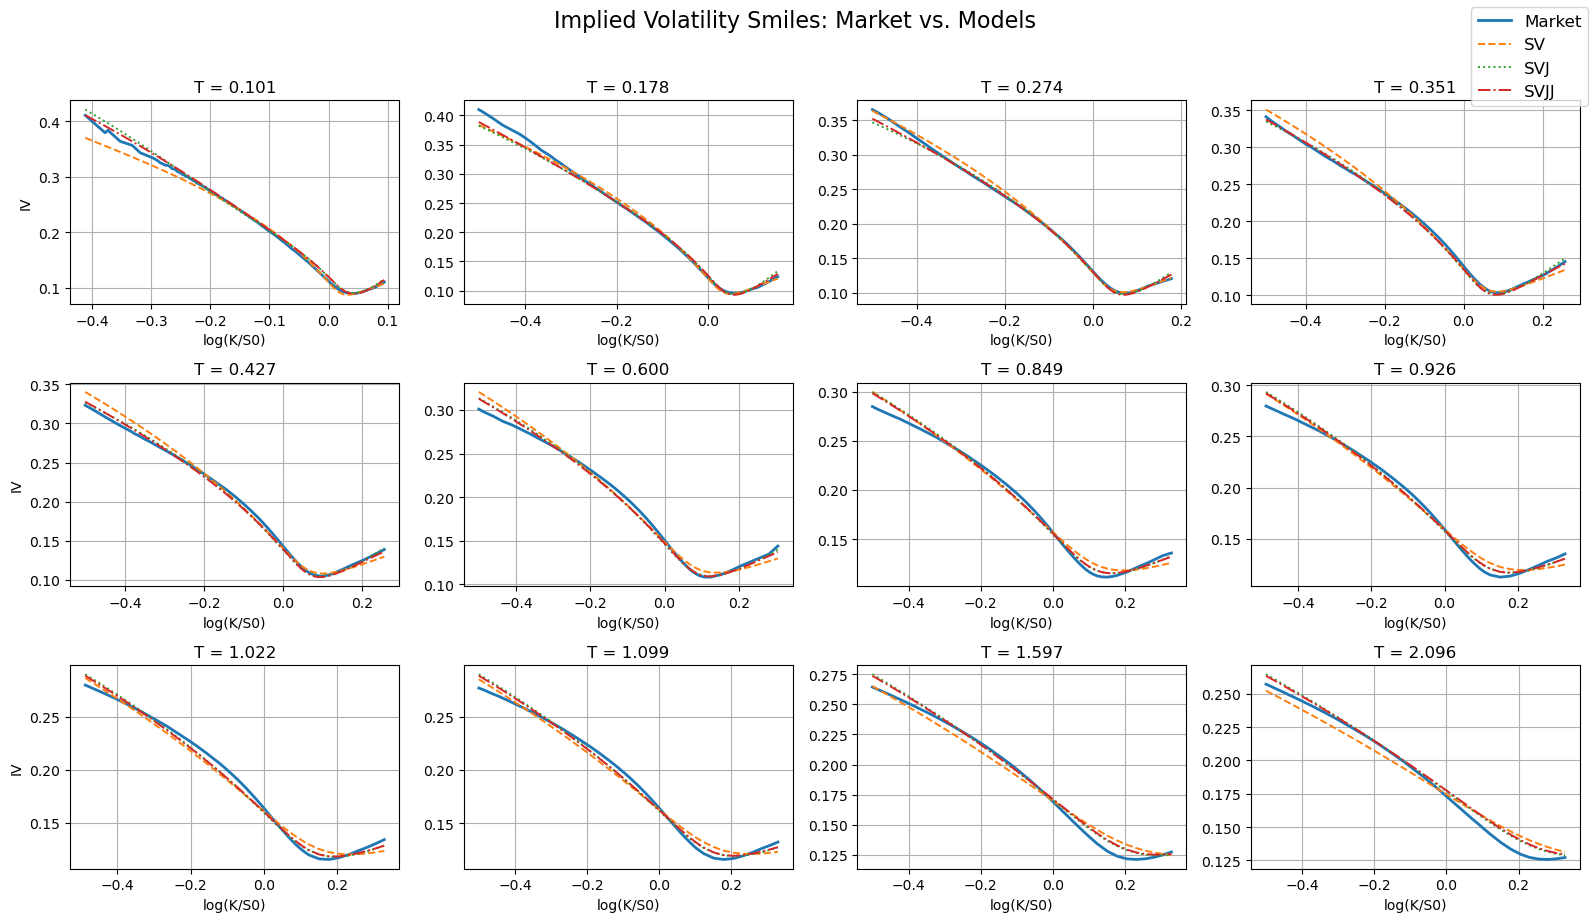

In [5]:
x0 = np.array([2.0, -0.5, 0.02, 0.1, 0.5, -0.6, 0.04, 0.2, 0.1, 0.02])
bounds = [
    (1e-6, 10.0),  # kappa
    (-1.0, 1.0),   # rho_J
    (1e-6, 10.0),  # mu_V
    (1e-6, 10.0),  # theta
    (1e-6, 10.0),  # eta
    (-1.0, 1.0),   # rho
    (1e-6, 10.0),  # v0
    (1e-6, 10.0),  # Lambda
    (-20, 20),     # mu_S
    (1e-6, 2.0)    # sigma
]

# Step 1: Nelder–Mead
res0 = minimize(lambda x: loss(x, q, S0, df), x0,
                method="Nelder-Mead",
                options={"maxiter": 50})

# Step 2: L-BFGS-B
res = minimize(lambda x: loss(x, q, S0, df), res0.x,
               bounds=bounds,
               method="L-BFGS-B",
               options={"maxiter": 50})

params_svjj = res.x
print("\nSVJJ params:", params_svjj)

# Pricing for plots
model_prices = []

for _, row in df.iterrows():
    model_prices.append(
        Lewis_call_option_pricing_sinh_tan(
            S0,
            row["Strike"],
            row["T"],
            row["r"],
            q,
            kappa=params_svjj[0],
            rho_J=params_svjj[1],
            mu_V=params_svjj[2],
            theta=params_svjj[3],
            eta=params_svjj[4],
            rho=params_svjj[5],
            V_t=params_svjj[6],
            Lambda=params_svjj[7],
            mu_S=params_svjj[8],
            sigma=params_svjj[9],
            X_t=np.log(S0),
            N=4096, alpha=1.2, L=24.0
        )
    )


df["SVJJ_price"] = model_prices
df["IV_model"] = [
    implied_vol_call(p, S0, K, T, r0, q)
    for p, K, T, r0 in zip(model_prices, df["Strike"], df["T"], df["r"])
]

df["IV_SVJJ"] = df["IV_model"]

# Visualize
# plot_market_and_model_surface(df, 80, "SVJJ Model")
# plot_smiles_market_vs_model(df, 80, "SVJJ Model")
print("SVJJ IV Error (RMSE):", compute_iv_errors(df))

plot_smiles_all_models(
    df,
    max_maturities=12,
    model_columns={
        "SV": "IV_SV",
        "SVJ": "IV_SVJ",
        "SVJJ": "IV_SVJJ"
    }
)

Calibrate VG model

In [6]:
vg0_only = VGParams_VG(theta=-0.2, sigma=0.12, nu=0.4)

# Calibration with prices in loss-function
vg_params_price = calibrate_vg_full_surface(df, vg0_only, loss_type="price")

vg_prices_price = []

for _, row in df.iterrows():
    vg_prices_price.append(
        price_slice_vg_maturity(
            row["T"], row["r"], row["q"],
            np.array([row["Strike"]]),
            vg_params_price,
            S0=S0,
            N_u=2048, alpha=1.2, L=24.0
        )[0]
    )

df["IV_model"] = [
    implied_vol_call(p, S0, K, T, r0, q)
    for p, K, T, r0 in zip(
        vg_prices_price, df["Strike"], df["T"], df["r"]
    )
]

df["IV_VG_price"] = df["IV_model"]

print("\nCalibrated VG (Price Loss) Parameters:")
print(vg_params_price)

# plot_market_and_model_surface(df, 80, "VG (Price Loss)")
# plot_smiles_market_vs_model(df, 80, "VG (Price Loss)")
print("VG-Price IV Error (RMSE):", compute_iv_errors(df))

# Calibration with IV in loss-function
vg_params_iv = calibrate_vg_full_surface(df, vg0_only, loss_type="iv")

vg_prices_iv = []
for _, row in df.iterrows():
    vg_prices_iv.append(
        price_slice_vg_maturity(
            row["T"], row["r"], row["q"],
            np.array([row["Strike"]]),
            vg_params_iv,
            S0=S0,
            N_u=2048, alpha=1.2, L=24.0
        )[0]
    )

df["IV_model"] = [
    implied_vol_call(p, S0, K, T, r0, q)
    for p, K, T, r0 in zip(
        vg_prices_iv, df["Strike"], df["T"], df["r"]
    )
]

df["IV_VG_iv"] = df["IV_model"]

print("\nCalibrated VG (IV loss) Parameters:")
print(vg_params_iv)

# plot_market_and_model_surface(df, 80, "VG-Only (IV Loss)")
# plot_smiles_market_vs_model(df, 80, "VG-Only (IV Loss)")
print("VG-IV IV Error (RMSE):", compute_iv_errors(df))

Calibrating VG model on 1220 options

Final VG parameters: VGParams(theta=-0.11533378727924362, sigma=0.14563222664993972, nu=1.4740670732314722)

Calibrated VG (Price Loss) Parameters:
VGParams(theta=-0.11533378727924362, sigma=0.14563222664993972, nu=1.4740670732314722)
VG-Price IV Error (RMSE): ['ARPE_IV: 0.1105640164', 'RMSE_IV: 0.0371017780']
Calibrating VG model on 1220 options

Final VG parameters: VGParams(theta=-0.175817075779734, sigma=0.1240684961058868, nu=0.46867832211158045)

Calibrated VG (IV loss) Parameters:
VGParams(theta=-0.175817075779734, sigma=0.1240684961058868, nu=0.46867832211158045)
VG-IV IV Error (RMSE): ['ARPE_IV: 0.0910006165', 'RMSE_IV: 0.0240126864']


Calibrate VG-CIR model


Calibrated VG (Price Loss) Parameters:
TCVGParams(vg=VGParams(theta=-0.3356189675713856, sigma=0.12010700723643224, nu=0.5330642515006428), cir=CIRParams(kappa=3.7051270769556206, theta=0.5843304971823103, xi=2.064959778646817, y0=0.4275198385142624))
VG–CIR (Price Loss) IV Error (RMSE): ['ARPE_IV: 0.1019980634', 'RMSE_IV: 0.0320895566']

Calibrated VG-CIR (IV loss) Parameters:
TCVGParams(vg=VGParams(theta=-0.2945547003772954, sigma=0.1538390261943339, nu=0.288769257038475), cir=CIRParams(kappa=2.2332994376939697, theta=0.9920980607080233, xi=1.7255026684027193, y0=0.34960975321463256))
VG–CIR (IV Loss) IV Error (RMSE): ['ARPE_IV: 0.0780817540', 'RMSE_IV: 0.0172308114']


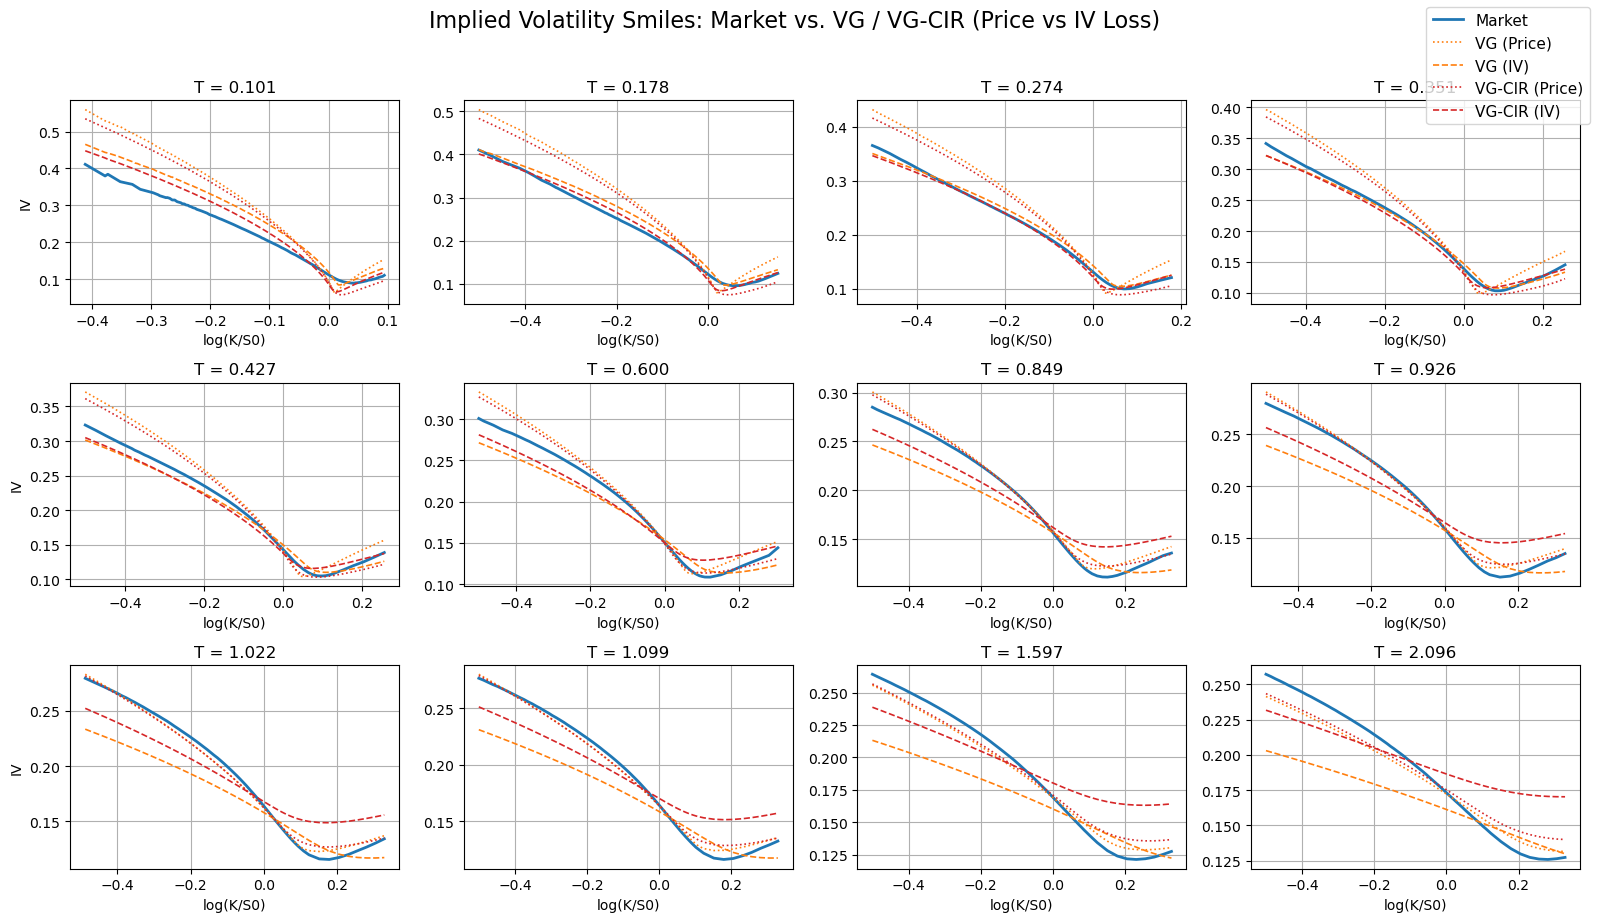

In [7]:
vg0_cir = VGParams_CIR(theta=-0.2, sigma=0.12, nu=0.4)
cir0 = CIRParams(kappa=1.0, theta=0.5, xi=1.0, y0=0.5)

# Calibration with prices in loss-function
params_vgcir_price = calibrate_vgcir(
    df, vg0_cir, cir0, loss_type="price"
)

vgcir_prices_price = []
for _, row in df.iterrows():
    vgcir_prices_price.append(
        price_vgcir_slice(
            row["T"], row["r"], row["q"],
            np.array([row["Strike"]]),
            params_vgcir_price,
            S0=S0,
            N_u=2048, alpha=1.2, L=20.0
        )[0]
    )

df["IV_model"] = [
    implied_vol_call(p, S0, K, T, r0, q)
    for p, K, T, r0 in zip(
        vgcir_prices_price, df["Strike"], df["T"], df["r"]
    )
]

df["IV_VGCIR_price"] = df["IV_model"]

print("\nCalibrated VG (Price Loss) Parameters:")
print(params_vgcir_price)

# plot_market_and_model_surface(df, 80, "VG–CIR (Price Loss)")
# plot_smiles_market_vs_model(df, 80, "VG–CIR (Price Loss)")
print("VG–CIR (Price Loss) IV Error (RMSE):", compute_iv_errors(df))

# Calibration with IV in loss-function
params_vgcir_iv = calibrate_vgcir(
    df, vg0_cir, cir0, loss_type="iv"
)

vgcir_prices_iv = []
for _, row in df.iterrows():
    vgcir_prices_iv.append(
        price_vgcir_slice(
            row["T"], row["r"], row["q"],
            np.array([row["Strike"]]),
            params_vgcir_iv,
            S0=S0,
            N_u=2048, alpha=1.2, L=20.0
        )[0]
    )

df["IV_model"] = [
    implied_vol_call(p, S0, K, T, r0, q)
    for p, K, T, r0 in zip(
        vgcir_prices_iv, df["Strike"], df["T"], df["r"]
    )
]

df["IV_VGCIR_iv"] = df["IV_model"]

print("\nCalibrated VG-CIR (IV loss) Parameters:")
print(params_vgcir_iv)

# plot_market_and_model_surface(df, 80, "VG–CIR (IV Loss)")
# plot_smiles_market_vs_model(df, 80, "VG–CIR (IV Loss)")
print("VG–CIR (IV Loss) IV Error (RMSE):", compute_iv_errors(df))

plot_smiles_vg_models(df, max_maturities=12)